In [1]:
import numpy as np
import scipy as sp
from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import *
from cvqaoa.cvdevice import KPOProcessor
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
from cvqaoa.plotlib import plotlib
plotlib.update_settings(usetex=True)
%config InlineBackend.figure_format = 'svg'

/Users/turbotanten/Documents/GitHub/cvqaoa/.env/lib/python3.9/site-packages/matplotlib_inline/config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


# Single Ising Spin

In [37]:
num_lvl = 12 # Hilbert space cut-off
a = destroy(num_lvl) # Annihilation operator
eye = qeye(num_lvl) # Identity operator

## Parameters
K = 1 # Kerr amplitude
G = 4 # Two-photon drive amplitude (in units of K)
alpha = np.sqrt(G/K) # Coherent state amplitude
Delta = 1/(alpha**2 * np.exp(-2*alpha**2)) # Detuning (in units of K)
E = 1 / (2*alpha)

# Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

# Computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

# Pauli Matrices in computational basis
# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())
# List with Paulis
sigma = [sigma_x, sigma_y, sigma_z]

In [35]:
H0 = - Delta*a.dag()*a - K*a.dag()**2*a**2
H1 = - K*a.dag()**2*a**2 + G*(a.dag()**2 + a**2) + E*(a.dag() + a)

HC = ket2dm(coherent(num_lvl,alpha)) - ket2dm(coherent(num_lvl,-alpha))

# Initialstate
initial_state = basis(num_lvl,0)

def variational_state(x:tuple):
    s = initial_state
    alphas, betas = x
    for alpha, beta in zip(alphas,betas):
        s = (-1j*H0*beta).expm() * (-1j*H1*alpha).expm() * s
    return s
    
const = (I.dag()*H1*I).tr()/2

def expval(x):
    p = int(len(x)/2)
    alphas = tuple(x[:p])
    betas = tuple(x[p:])
    x = (alphas,betas)
    return expect(sigma_z,variational_state(x))

### Compute success probability

In [29]:
X = res[2][0]
Y = res[2][1]
Z = res[3]

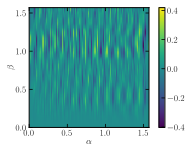

In [30]:
"""Save a figure"""
fig, ax = plotlib.create_fig(single_col=True,nrows=1)

im = ax.imshow(Z, 
              interpolation ='nearest', 
              origin ='lower',
              extent=[X.min(), X.max(), Y.min(), Y.max()]);

fig.colorbar(im)
ax.set_xlabel(r"$\alpha$");
ax.set_ylabel(r"$\beta$");
#ax.set_xlim([0.8,6.2]);
#ax.set_ylabel("mean approx. ratio")
#ax.set_xlabel("qaoa level")
#ax.set_ylim([0.75,1]);

In [13]:
prob_a = (res[1]+1)/2
prob_b = 1 - prob_a
print(prob_a, prob_b)

0.2423740441451444 0.7576259558548556


### Compute the fidelity

In [41]:
lvl = 1
alphas = tuple(res[0][:lvl])
betas = tuple(res[0][lvl:])
x = (alphas,betas)
s = variational_state(x)
# Compute the success probability
fidelity(s,down)

0.7507778420929393

# Cat State

In [2]:
N = 12 # Hilbert space cut-off
a = destroy(N) # Annihilation operator
eye = qeye(N) # Identity operator

## Parameters
K = 1 # Kerr amplitude
G = 4 # Two-photon drive amplitude (in units of K)
alpha = np.sqrt(G/K) # Coherent state amplitude
Delta = 1 # Detuning (in units of K)

H0 = - Delta*a.dag()*a - K*a.dag()**2*a**2
H1 = - K*a.dag()**2*a**2 + G*(a.dag()**2 + a**2)

# Initialstate
initial_state = basis(N,0)

# Cat state
cat_plus = (coherent(N,alpha) + coherent(N,-alpha)).unit()

def variational_state(x:tuple):
    s = initial_state
    alphas, betas = x
    for alpha, beta in zip(alphas,betas):
        s = (-1j*H0*beta).expm() * (-1j*H1*alpha).expm() * s
    return s
    
def expval(x):
    p = int(len(x)/2)
    alphas = tuple(x[:p])
    betas = tuple(x[p:])
    x = (alphas,betas)
    return (1-fidelity(variational_state(x), cat_plus))

In [99]:
x = [0.2292,0.2207,0.2207,0.6725,0.0444,0.0444]
expval(x)

0.3258809493581044

In [95]:
np.random.rand(4)*20

array([17.58924986, 10.45423796,  0.48076207, 15.3655091 ])

In [96]:
x = np.random.rand(8)*np.pi
res = sp.optimize.minimize(expval, x)
res

((2.542514879730104, 2.4170764671965608, 1.7205411789627534, 2.247550767440991), (2.6820362380216496, 0.6298137047119855, 1.5601397241789763, 1.9425786329746788))
((2.542514879730104, 2.4170764671965608, 1.7205411789627534, 2.247550767440991), (2.6820362380216496, 0.6298137047119855, 1.5601397241789763, 1.9425786329746788))
((2.5425148946312652, 2.4170764671965608, 1.7205411789627534, 2.247550767440991), (2.6820362380216496, 0.6298137047119855, 1.5601397241789763, 1.9425786329746788))
((2.5425148946312652, 2.4170764671965608, 1.7205411789627534, 2.247550767440991), (2.6820362380216496, 0.6298137047119855, 1.5601397241789763, 1.9425786329746788))
((2.542514879730104, 2.417076482097722, 1.7205411789627534, 2.247550767440991), (2.6820362380216496, 0.6298137047119855, 1.5601397241789763, 1.9425786329746788))
((2.542514879730104, 2.417076482097722, 1.7205411789627534, 2.247550767440991), (2.6820362380216496, 0.6298137047119855, 1.5601397241789763, 1.9425786329746788))
((2.542514879730104, 2

((2.5365201464441727, 1.8611108177542306, 1.198630503383739, 1.6646092845343565), (2.572479089049169, 0.5119386380239703, 1.363290681378594, 1.6967626847314945))
((2.5365201464441727, 1.8611108177542306, 1.198630503383739, 1.6646092845343565), (2.572479089049169, 0.5119386380239703, 1.363290681378594, 1.6967626847314945))
((2.5365201315430115, 1.8611108326553918, 1.198630503383739, 1.6646092845343565), (2.572479089049169, 0.5119386380239703, 1.363290681378594, 1.6967626847314945))
((2.5365201315430115, 1.8611108326553918, 1.198630503383739, 1.6646092845343565), (2.572479089049169, 0.5119386380239703, 1.363290681378594, 1.6967626847314945))
((2.5365201315430115, 1.8611108177542306, 1.1986305182849002, 1.6646092845343565), (2.572479089049169, 0.5119386380239703, 1.363290681378594, 1.6967626847314945))
((2.5365201315430115, 1.8611108177542306, 1.1986305182849002, 1.6646092845343565), (2.572479089049169, 0.5119386380239703, 1.363290681378594, 1.6967626847314945))
((2.5365201315430115, 1.86

((2.522810241973543, 1.8541335025459007, 1.17574078056656, 1.6831602930531955), (2.5981537124477505, 0.5454075489633214, 1.3464374458609132, 1.6928522712328882))
((2.522810241973543, 1.8541335025459007, 1.17574078056656, 1.6831602930531955), (2.5981537124477505, 0.5454075489633214, 1.3464374458609132, 1.6928522712328882))
((2.522810241973543, 1.8541335025459007, 1.1757407656653989, 1.6831603079543567), (2.5981537124477505, 0.5454075489633214, 1.3464374458609132, 1.6928522712328882))
((2.522810241973543, 1.8541335025459007, 1.1757407656653989, 1.6831603079543567), (2.5981537124477505, 0.5454075489633214, 1.3464374458609132, 1.6928522712328882))
((2.522810241973543, 1.8541335025459007, 1.1757407656653989, 1.6831602930531955), (2.5981537273489117, 0.5454075489633214, 1.3464374458609132, 1.6928522712328882))
((2.522810241973543, 1.8541335025459007, 1.1757407656653989, 1.6831602930531955), (2.5981537273489117, 0.5454075489633214, 1.3464374458609132, 1.6928522712328882))
((2.522810241973543,

((2.4902251670561095, 1.8460887750859274, 1.1879479368712846, 1.6945661678645478), (2.5987694291483554, 0.561664710027, 1.3434084023341146, 1.674298980329183))
((2.4902251670561095, 1.8460887750859274, 1.1879479368712846, 1.6945661678645478), (2.5987694291483554, 0.561664710027, 1.3434084023341146, 1.674298980329183))
((2.4902251521549483, 1.8460887899870886, 1.1879479368712846, 1.6945661678645478), (2.5987694291483554, 0.561664710027, 1.3434084023341146, 1.674298980329183))
((2.4902251521549483, 1.8460887899870886, 1.1879479368712846, 1.6945661678645478), (2.5987694291483554, 0.561664710027, 1.3434084023341146, 1.674298980329183))
((2.4902251521549483, 1.8460887750859274, 1.1879479517724458, 1.6945661678645478), (2.5987694291483554, 0.561664710027, 1.3434084023341146, 1.674298980329183))
((2.4902251521549483, 1.8460887750859274, 1.1879479517724458, 1.6945661678645478), (2.5987694291483554, 0.561664710027, 1.3434084023341146, 1.674298980329183))
((2.4902251521549483, 1.8460887750859274

((2.4926407524692866, 1.846501090955535, 1.1832062363542852, 1.6942780862848603), (2.598447550145637, 0.5609756314252545, 1.341259227882326, 1.6867016392960488))
((2.4926407524692866, 1.846501090955535, 1.1832062363542852, 1.6942780862848603), (2.598447550145637, 0.5609756314252545, 1.341259227882326, 1.6867016392960488))
((2.4926407375681254, 1.8465011058566962, 1.1832062363542852, 1.6942780862848603), (2.598447550145637, 0.5609756314252545, 1.341259227882326, 1.6867016392960488))
((2.4926407375681254, 1.8465011058566962, 1.1832062363542852, 1.6942780862848603), (2.598447550145637, 0.5609756314252545, 1.341259227882326, 1.6867016392960488))
((2.4926407375681254, 1.846501090955535, 1.1832062512554464, 1.6942780862848603), (2.598447550145637, 0.5609756314252545, 1.341259227882326, 1.6867016392960488))
((2.4926407375681254, 1.846501090955535, 1.1832062512554464, 1.6942780862848603), (2.598447550145637, 0.5609756314252545, 1.341259227882326, 1.6867016392960488))
((2.4926407375681254, 1.84

((2.4992003752795364, 1.834556731214495, 1.1891537835874635, 1.691236329134754), (2.6103264865123887, 0.5566400007796225, 1.3307606186088805, 1.6910264368841925))
((2.4992003752795364, 1.834556731214495, 1.1891537835874635, 1.691236329134754), (2.6103264865123887, 0.5566400007796225, 1.3307606186088805, 1.6910264368841925))
((2.4992003752795364, 1.8345567163133338, 1.1891537984886247, 1.691236329134754), (2.6103264865123887, 0.5566400007796225, 1.3307606186088805, 1.6910264368841925))
((2.4992003752795364, 1.8345567163133338, 1.1891537984886247, 1.691236329134754), (2.6103264865123887, 0.5566400007796225, 1.3307606186088805, 1.6910264368841925))
((2.4992003752795364, 1.8345567163133338, 1.1891537835874635, 1.6912363440359153), (2.6103264865123887, 0.5566400007796225, 1.3307606186088805, 1.6910264368841925))
((2.4992003752795364, 1.8345567163133338, 1.1891537835874635, 1.6912363440359153), (2.6103264865123887, 0.5566400007796225, 1.3307606186088805, 1.6910264368841925))
((2.499200375279

((2.4989389762981293, 1.8364940020402867, 1.1889259572464872, 1.690146118782445), (2.609497875189733, 0.5484482277666298, 1.3273551606199654, 1.6992656762395904))
((2.4989389762981293, 1.8364940020402867, 1.1889259572464872, 1.690146118782445), (2.609497875189733, 0.5484482277666298, 1.3273551606199654, 1.6992656762395904))
((2.4989389762981293, 1.8364940020402867, 1.1889259572464872, 1.6901461038812837), (2.609497890090894, 0.5484482277666298, 1.3273551606199654, 1.6992656762395904))
((2.4989389762981293, 1.8364940020402867, 1.1889259572464872, 1.6901461038812837), (2.609497890090894, 0.5484482277666298, 1.3273551606199654, 1.6992656762395904))
((2.4989389762981293, 1.8364940020402867, 1.1889259572464872, 1.6901461038812837), (2.609497875189733, 0.548448242667791, 1.3273551606199654, 1.6992656762395904))
((2.4989389762981293, 1.8364940020402867, 1.1889259572464872, 1.6901461038812837), (2.609497875189733, 0.548448242667791, 1.3273551606199654, 1.6992656762395904))
((2.4989389762981293

((2.4866160935229615, 1.8429239881959334, 1.192095438299594, 1.6891106959185096), (2.606755913086593, 0.5380820028389988, 1.3271642328143756, 1.6984215464903416))
((2.4866160935229615, 1.8429239881959334, 1.192095438299594, 1.6891106959185096), (2.606755913086593, 0.5380820028389988, 1.3271642328143756, 1.6984215464903416))
((2.4866160935229615, 1.8429239881959334, 1.192095438299594, 1.6891106959185096), (2.606755913086593, 0.5380819879378376, 1.3271642477155368, 1.6984215464903416))
((2.4866160935229615, 1.8429239881959334, 1.192095438299594, 1.6891106959185096), (2.606755913086593, 0.5380819879378376, 1.3271642477155368, 1.6984215464903416))
((2.4866160935229615, 1.8429239881959334, 1.192095438299594, 1.6891106959185096), (2.606755913086593, 0.5380819879378376, 1.3271642328143756, 1.6984215613915028))
((2.4866160935229615, 1.8429239881959334, 1.192095438299594, 1.6891106959185096), (2.606755913086593, 0.5380819879378376, 1.3271642328143756, 1.6984215613915028))
((2.490497224053368, 1

((2.490922776196205, 1.84160786003354, 1.191092873509686, 1.6898102806071111), (2.607463831099056, 0.5402562884987829, 1.3266190885895741, 1.699009087010721))
((2.490922776196205, 1.84160786003354, 1.191092873509686, 1.6898102806071111), (2.607463831099056, 0.5402562884987829, 1.3266190885895741, 1.699009087010721))
((2.490922776196205, 1.84160786003354, 1.191092873509686, 1.6898102806071111), (2.607463831099056, 0.5402562884987829, 1.326619073688413, 1.6990091019118823))
((2.490922776196205, 1.84160786003354, 1.191092873509686, 1.6898102806071111), (2.607463831099056, 0.5402562884987829, 1.326619073688413, 1.6990091019118823))
((2.4922845430532834, 1.8435647185336799, 1.1906853437900238, 1.6915571036969825), (2.6077409046366298, 0.5378706289906245, 1.3236834619933238, 1.7008698979857884))
((2.4922845430532834, 1.8435647185336799, 1.1906853437900238, 1.6915571036969825), (2.6077409046366298, 0.5378706289906245, 1.3236834619933238, 1.7008698979857884))
((2.4922845579544446, 1.8435647185

((2.5004707101281327, 1.8448305101763793, 1.1920136050192205, 1.6912194953597568), (2.61196054055878, 0.5319199523439004, 1.313629459557607, 1.7077937134298096))
((2.5004707101281327, 1.8448305101763793, 1.1920136050192205, 1.6912194953597568), (2.61196054055878, 0.5319199523439004, 1.313629459557607, 1.7077937134298096))
((2.5004707101281327, 1.8448305101763793, 1.1920136050192205, 1.6912194953597568), (2.61196054055878, 0.5319199374427392, 1.3136294744587682, 1.7077937134298096))
((2.5004707101281327, 1.8448305101763793, 1.1920136050192205, 1.6912194953597568), (2.61196054055878, 0.5319199374427392, 1.3136294744587682, 1.7077937134298096))
((2.5004707101281327, 1.8448305101763793, 1.1920136050192205, 1.6912194953597568), (2.61196054055878, 0.5319199374427392, 1.313629459557607, 1.7077937283309708))
((2.5004707101281327, 1.8448305101763793, 1.1920136050192205, 1.6912194953597568), (2.61196054055878, 0.5319199374427392, 1.313629459557607, 1.7077937283309708))
((2.5020594730984747, 1.84

((2.4990344439813956, 1.8465832401213012, 1.1927699277485748, 1.688498197049422), (2.610033341812042, 0.5292977396171354, 1.315134241930008, 1.7133878522167298))
((2.4990344439813956, 1.8465832401213012, 1.1927699277485748, 1.688498197049422), (2.610033341812042, 0.5292977396171354, 1.315134241930008, 1.7133878522167298))
((2.4990344439813956, 1.8465832401213012, 1.1927699277485748, 1.688498197049422), (2.610033341812042, 0.5292977396171354, 1.3151342270288469, 1.713387867117891))
((2.4990344439813956, 1.8465832401213012, 1.1927699277485748, 1.688498197049422), (2.610033341812042, 0.5292977396171354, 1.3151342270288469, 1.713387867117891))
((2.5004710066075, 1.846341845425549, 1.192758900299413, 1.6892330184478956), (2.6111241847378763, 0.5291025213257704, 1.3134899796549173, 1.7128382623352936))
((2.5004710066075, 1.846341845425549, 1.192758900299413, 1.6892330184478956), (2.6111241847378763, 0.5291025213257704, 1.3134899796549173, 1.7128382623352936))
((2.500471021508661, 1.846341845

((2.5007388163487807, 1.846547641668461, 1.193216682175111, 1.6884073458973896), (2.6116586992727684, 0.5287646354070176, 1.3125199931628617, 1.714035282802722))
((2.5007388163487807, 1.846547641668461, 1.193216682175111, 1.6884073458973896), (2.6116586992727684, 0.5287646354070176, 1.3125199931628617, 1.714035282802722))
((2.500738831249942, 1.846547641668461, 1.193216682175111, 1.6884073458973896), (2.6116586992727684, 0.5287646354070176, 1.3125199931628617, 1.714035282802722))
((2.500738831249942, 1.846547641668461, 1.193216682175111, 1.6884073458973896), (2.6116586992727684, 0.5287646354070176, 1.3125199931628617, 1.714035282802722))
((2.5007388163487807, 1.8465476565696222, 1.193216682175111, 1.6884073458973896), (2.6116586992727684, 0.5287646354070176, 1.3125199931628617, 1.714035282802722))
((2.5007388163487807, 1.8465476565696222, 1.193216682175111, 1.6884073458973896), (2.6116586992727684, 0.5287646354070176, 1.3125199931628617, 1.714035282802722))
((2.5007388163487807, 1.8465

((2.500606118631987, 1.8468464177799555, 1.1931213353376613, 1.688601302759009), (2.611472525787821, 0.5283925666275814, 1.3125975074437564, 1.714078926450304))
((2.500606118631987, 1.8468464177799555, 1.1931213353376613, 1.688601302759009), (2.611472525787821, 0.5283925666275814, 1.3125975074437564, 1.714078926450304))
((2.500606118631987, 1.8468464028787943, 1.1931213502388225, 1.688601302759009), (2.611472525787821, 0.5283925666275814, 1.3125975074437564, 1.714078926450304))
((2.500606118631987, 1.8468464028787943, 1.1931213502388225, 1.688601302759009), (2.611472525787821, 0.5283925666275814, 1.3125975074437564, 1.714078926450304))
((2.500606118631987, 1.8468464028787943, 1.1931213353376613, 1.6886013176601702), (2.611472525787821, 0.5283925666275814, 1.3125975074437564, 1.714078926450304))
((2.500606118631987, 1.8468464028787943, 1.1931213353376613, 1.6886013176601702), (2.611472525787821, 0.5283925666275814, 1.3125975074437564, 1.714078926450304))
((2.500606118631987, 1.846846402

((2.500599273007669, 1.8468327084869025, 1.1931406702114429, 1.6885676650888604), (2.6114819980711914, 0.5284049419710332, 1.312607881700604, 1.714079436722659))
((2.500599273007669, 1.8468327084869025, 1.1931406702114429, 1.6885676650888604), (2.6114819980711914, 0.5284049419710332, 1.312607881700604, 1.714079436722659))
((2.500599273007669, 1.8468327084869025, 1.1931406702114429, 1.6885676501876992), (2.6114820129723526, 0.5284049419710332, 1.312607881700604, 1.714079436722659))
((2.500599273007669, 1.8468327084869025, 1.1931406702114429, 1.6885676501876992), (2.6114820129723526, 0.5284049419710332, 1.312607881700604, 1.714079436722659))
((2.500599273007669, 1.8468327084869025, 1.1931406702114429, 1.6885676501876992), (2.6114819980711914, 0.5284049568721944, 1.312607881700604, 1.714079436722659))
((2.500599273007669, 1.8468327084869025, 1.1931406702114429, 1.6885676501876992), (2.6114819980711914, 0.5284049568721944, 1.312607881700604, 1.714079436722659))
((2.500599273007669, 1.84683

((2.500491983299781, 1.84677033796782, 1.1932964263123294, 1.6884682274293896), (2.6116063991855425, 0.5284333140876947, 1.3124812347165662, 1.7141656361087338))
((2.500491983299781, 1.84677033796782, 1.1932964263123294, 1.6884682274293896), (2.6116063991855425, 0.5284333140876947, 1.3124812347165662, 1.7141656361087338))
((2.500491983299781, 1.84677033796782, 1.1932964263123294, 1.6884682274293896), (2.6116063842843813, 0.5284333289888559, 1.3124812347165662, 1.7141656361087338))
((2.500491983299781, 1.84677033796782, 1.1932964263123294, 1.6884682274293896), (2.6116063842843813, 0.5284333289888559, 1.3124812347165662, 1.7141656361087338))
((2.500491983299781, 1.84677033796782, 1.1932964263123294, 1.6884682274293896), (2.6116063842843813, 0.5284333140876947, 1.3124812496177274, 1.7141656361087338))
((2.500491983299781, 1.84677033796782, 1.1932964263123294, 1.6884682274293896), (2.6116063842843813, 0.5284333140876947, 1.3124812496177274, 1.7141656361087338))
((2.500491983299781, 1.84677

((2.5000373104856837, 1.8468603241226387, 1.1935430055041016, 1.6882156196423954), (2.611973767532592, 0.528526492172134, 1.312132545539936, 1.7144745478934909))
((2.5000373104856837, 1.8468603241226387, 1.1935430055041016, 1.6882156196423954), (2.611973767532592, 0.528526492172134, 1.312132545539936, 1.7144745478934909))
((2.5000372955845225, 1.8468603390237999, 1.1935430055041016, 1.6882156196423954), (2.611973767532592, 0.528526492172134, 1.312132545539936, 1.7144745478934909))
((2.5000372955845225, 1.8468603390237999, 1.1935430055041016, 1.6882156196423954), (2.611973767532592, 0.528526492172134, 1.312132545539936, 1.7144745478934909))
((2.5000372955845225, 1.8468603241226387, 1.1935430204052628, 1.6882156196423954), (2.611973767532592, 0.528526492172134, 1.312132545539936, 1.7144745478934909))
((2.5000372955845225, 1.8468603241226387, 1.1935430204052628, 1.6882156196423954), (2.611973767532592, 0.528526492172134, 1.312132545539936, 1.7144745478934909))
((2.5000372955845225, 1.8468

((2.5000431132658623, 1.8468565048094348, 1.1935384668882978, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384668882978, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175557537273), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175557537273), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.61197176919074, 0.528527416363281, 1.3121355975266873, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.61197176919074, 0.528527416363281, 1.3121355975266873, 1.7144698692937153))
((2.5000431132658623, 1.

((2.5000431121535907, 1.8468565050793526, 1.1935384527693464, 1.6882175403060018), (2.6119717699243283, 0.5285274164271524, 1.3121355967463988, 1.7144698701144816))
((2.5000431121535907, 1.8468565050793526, 1.1935384527693464, 1.6882175403060018), (2.6119717699243283, 0.5285274164271524, 1.3121355967463988, 1.7144698701144816))
((2.5000431121535907, 1.8468565050793526, 1.1935384527693464, 1.6882175403060018), (2.611971755023167, 0.5285274313283136, 1.3121355967463988, 1.7144698701144816))
((2.5000431121535907, 1.8468565050793526, 1.1935384527693464, 1.6882175403060018), (2.611971755023167, 0.5285274313283136, 1.3121355967463988, 1.7144698701144816))
((2.5000431121535907, 1.8468565050793526, 1.1935384527693464, 1.6882175403060018), (2.611971755023167, 0.5285274164271524, 1.31213561164756, 1.7144698701144816))
((2.5000431121535907, 1.8468565050793526, 1.1935384527693464, 1.6882175403060018), (2.611971755023167, 0.5285274164271524, 1.31213561164756, 1.7144698701144816))
((2.50004311215359

((2.500043113263681, 1.846856504809964, 1.1935384519886707, 1.6882175408514943), (2.6119717542910177, 0.5285274312645675, 1.312135597525157, 1.7144698692953249))
((2.500043113263681, 1.846856504809964, 1.1935384519886707, 1.6882175408514943), (2.6119717542910177, 0.5285274312645675, 1.312135597525157, 1.7144698692953249))
((2.500043113263681, 1.846856504809964, 1.1935384519886707, 1.6882175408514943), (2.6119717542910177, 0.5285274163634063, 1.3121356124263182, 1.7144698692953249))
((2.500043113263681, 1.846856504809964, 1.1935384519886707, 1.6882175408514943), (2.6119717542910177, 0.5285274163634063, 1.3121356124263182, 1.7144698692953249))
((2.500043113263681, 1.846856504809964, 1.1935384519886707, 1.6882175408514943), (2.6119717542910177, 0.5285274163634063, 1.312135597525157, 1.714469884196486))
((2.500043113263681, 1.846856504809964, 1.1935384519886707, 1.6882175408514943), (2.6119717542910177, 0.5285274163634063, 1.312135597525157, 1.714469884196486))
((2.5000431132658623, 1.8468

((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121356124278485, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121356124278485, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698841948764))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698841948764))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871368, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698692937155))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871368, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698692937155))
((2.5000431281670235, 

((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121356124278485, 1.7144698692937155))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121356124278485, 1.7144698692937155))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698841948767))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698841948767))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698692937153))
((2.5000431281670235, 

((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175557537273), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698692937155))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175557537273), (2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698692937155))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.61197176919074, 0.528527416363281, 1.3121355975266873, 1.7144698692937155))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.61197176919074, 0.528527416363281, 1.3121355975266873, 1.7144698692937155))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.5285274312644422, 1.3121355975266873, 1.7144698692937155))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.5285274312644422, 1.3121355975266873, 1.7144698692937155))
((2.5000431132658623, 

((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.61197176919074, 0.528527416363281, 1.3121355975266873, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.61197176919074, 0.528527416363281, 1.3121355975266873, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.5285274312644422, 1.3121355975266873, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.5285274312644422, 1.3121355975266873, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121356124278485, 1.7144698692937153))
((2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661), (2.611971754289579, 0.528527416363281, 1.3121356124278485, 1.7144698692937153))
((2.5000431132658623, 

      fun: 0.03159463994266387
 hess_inv: array([[ 3.32177826e-03, -9.68482881e-04, -2.18711151e-03,
         1.51099283e-03, -2.18102634e-03, -1.78403187e-04,
         2.30858488e-03, -2.47533056e-03],
       [-9.68482881e-04,  5.06072710e-04,  4.39408416e-04,
        -2.72816083e-04,  4.99690671e-04, -9.68316674e-06,
        -6.11117048e-04,  7.11072873e-04],
       [-2.18711151e-03,  4.39408416e-04,  1.65071526e-03,
        -1.16944998e-03,  1.55877224e-03,  1.85329466e-04,
        -1.60316694e-03,  1.62950015e-03],
       [ 1.51099283e-03, -2.72816083e-04, -1.16944998e-03,
         9.05706067e-04, -1.14718649e-03, -1.71868894e-04,
         1.10915175e-03, -1.10653224e-03],
       [-2.18102634e-03,  4.99690671e-04,  1.55877224e-03,
        -1.14718649e-03,  1.59606607e-03,  1.71020812e-04,
        -1.54939064e-03,  1.63217332e-03],
       [-1.78403187e-04, -9.68316674e-06,  1.85329466e-04,
        -1.71868894e-04,  1.71020812e-04,  5.89860654e-05,
        -1.52784037e-04,  1.1934145

In [97]:
xvec = np.linspace(-4, 4, 400); yvec = np.linspace(-2, 2, 200)
state = variational_state(list(res.x))
W = wigner(state,xvec,yvec,'iterative',2)
nrm = mpl.colors.Normalize(-W.max(), W.max()) # Normalize colors

# contour plot
plt.subplot(121,aspect='equal')
im = plt.contourf(xvec, yvec, W, 100, cmap = cm.RdBu_r, norm = nrm) # density plot
plt.xlabel(r'Re$(\alpha)$', fontsize = 14)
plt.ylabel(r'Im$(\alpha)$', fontsize = 14)
plt.xticks(np.arange(min(xvec),max(xvec)+1,2),fontsize = 12)
plt.yticks(np.arange(min(yvec),max(yvec)+1,2),fontsize = 12)

cat_plus = (coherent(N,alpha) + coherent(N,-alpha)).unit()
print(fidelity(state,cat_plus))

[2.5000431132658623, 1.8468565048094348, 1.1935384519871366, 1.6882175408525661, 2.611971754289579, 0.528527416363281, 1.3121355975266873, 1.7144698692937153]


ValueError: too many values to unpack (expected 2)